데이터셋 준비 
IMDB에서 제공하는 영화 리뷰 데이터셋 이용

## IMDB 데이터셋

--> 인터넷 영화 데이터베이스로부터 가져온 양극단의 리뷰 5만 개. 
<br>훈련 데이터 25000개, 테스트 데이터 25000개로 나뉘고 각각 50%는 부정, 50%는 긍정 리뷰로 구성됨.

## 1. 데이터셋 생성

훈련 데이터 25000개를 훈련 데이터 20000개, 검증 데이터 5000개로 분리 

분리 후 리뷰의 길이를 맞춰주기 위해 sequence를 사용하여 padding으로 0을 채워주거나 단어 길이의 최대값이 넘어가지 않도록 잘라내어 조정함.

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, CuDNNLSTM
from keras.layers import Dropout, Conv1D, MaxPooling1D
import numpy as np


max_features = 20000
text_max_words = 200

np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)
np.load = np_load_old

x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

Using TensorFlow backend.


## 2. 모델 구성
컨볼루션 신경망 모델 구성
<br>컨볼루션 신경망(CNN) : 하나 또는 여러개의 컨볼루션 레이어와 그 위에 올려진 일반적인 인공 신경망 레이어들로 이루어져 컨볼루션 레이어에서 전처리를 수행하는 구조.
<br>2차원 입력 데이터에 적합.
<br>학습된 내용 기반으로 새로운 입력에 대해 답을 얻어내고 귀납적으로 배움.

In [3]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=text_max_words))
model.add(Dropout(0.2))
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(CuDNNLSTM(128))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

W0808 03:23:06.480844 140337019500416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 03:23:06.499841 140337019500416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 03:23:06.501995 140337019500416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 03:23:06.515922 140337019500416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0808 03:23:06.524339 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 256)          98560     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 256)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 128)               197632    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,856,321
Trainable params: 2,856,321
Non-trainable params: 0
_________________________________________________________________


## 3. 모델 학습과정 설정


In [4]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

W0808 03:23:07.594011 140337019500416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0808 03:23:07.619804 140337019500416 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0808 03:23:07.627341 140337019500416 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## 4. 모델 학습

In [5]:
hist = model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_val, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/25
20000/20000 [==============================] - 7s 349us/step - loss: 0.4003 - acc: 0.8024 - val_loss: 0.3172 - val_acc: 0.8666
Epoch 2/25
20000/20000 [==============================] - 4s 190us/step - loss: 0.1853 - acc: 0.9302 - val_loss: 0.3386 - val_acc: 0.8602
Epoch 3/25
20000/20000 [==============================] - 4s 190us/step - loss: 0.0935 - acc: 0.9682 - val_loss: 0.3606 - val_acc: 0.8654
Epoch 4/25
20000/20000 [==============================] - 4s 193us/step - loss: 0.0527 - acc: 0.9834 - val_loss: 0.4742 - val_acc: 0.8604
Epoch 5/25
20000/20000 [==============================] - 4s 191us/step - loss: 0.0320 - acc: 0.9905 - val_loss: 0.4956 - val_acc: 0.8586
Epoch 6/25
20000/20000 [==============================] - 4s 193us/step - loss: 0.0195 - acc: 0.9940 - val_loss: 0.6242 - val_acc: 0.8556
Epoch 7/25
20000/20000 [==============================] - 4s 192us/step - loss: 0.0149 - acc: 0.9954 - val_loss: 0.6862 - v

## 5. 학습과정 보기

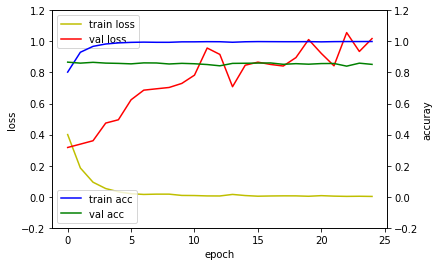

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


## 6. 모델 평가

In [7]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

25000/25000 [==============================] - 2s 60us/step
## evaluation loss and_metrics ##
[1.2075521323394776, 0.8263600000190735]
